# Dataset Preparation


### Setup

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

seed = 1855
dataset_url = "https://dati.comune.milano.it/dataset/dba09f14-b87c-4001-b2f4-24bce4ae6726/resource/d8118628-1bb7-40ba-9214-dababde38f20/download/portale_istituzionale_mobile_daterangeday_20240813.csv"

## Data Collection


In [65]:
dataset = pd.read_csv(dataset_url, sep=';', encoding='latin1')


## Handling missing values and clean up


In [66]:
# Checking if there are any missing values

dataset.isnull().sum()

# dropping elaboration_date column as it's irrelevant for this analysis
dataset.drop(columns=['data_elaborazione'], inplace=True)

# drop ambito and tipologia as they are constant
dataset.drop(columns=['ambito', 'tipologia'], inplace=True)

# Extracting the date number from the date column, no need to extract year and month as they are already in the dataset

dataset['giorno'] = dataset['data'].apply(lambda x: int(x.split('-')[2]))

# sort by data (first convert to datetime)
dataset['data'] = pd.to_datetime(dataset['data'])
dataset = dataset.sort_values(by='data')

# Dropping the data column as we have extracted the day number
dataset.drop(columns=['data'], inplace=True)

dataset.head()


,anno,mese_num,pageviews,giorno
2415,2018,1,17075,1
2414,2018,1,48740,2
2413,2018,1,52886,3
2412,2018,1,50195,4
2411,2018,1,44462,5


## Encoding categorical features with One-Hot Encoding


In [67]:
categorical_features = dataset.select_dtypes(include=['object']).columns.tolist()
dataset = pd.get_dummies(dataset, columns=categorical_features)

dataset.head()

,anno,mese_num,pageviews,giorno
2415,2018,1,17075,1
2414,2018,1,48740,2
2413,2018,1,52886,3
2412,2018,1,50195,4
2411,2018,1,44462,5


## Encoding binary class label


In [68]:
# just moving the target column to the end of the dataframe
target = dataset['pageviews']
dataset.drop(columns=['pageviews'], inplace=True)
dataset['pageviews'] = target
dataset.head()

,anno,mese_num,giorno,pageviews
2415,2018,1,1,17075
2414,2018,1,2,48740
2413,2018,1,3,52886
2412,2018,1,4,50195
2411,2018,1,5,44462


# Model Building


In [69]:
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.neighbors import *
from sklearn.svm import *
import matplotlib.pyplot as plt

## Splitting the dataset into training and testing sets


In [70]:
x = dataset.drop(columns=['pageviews'])
y = dataset['pageviews']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

## Evaluation function


In [71]:
def evaluate(expected, predicted):
    print('Mean Absolute Error:', mean_absolute_error(expected, predicted))
    print('Mean Squared Error:', mean_squared_error(expected, predicted))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(expected, predicted)))
    print('R2 Score:', r2_score(expected, predicted))
    
def display_confusion_matrix(expected, predicted):
    cm = confusion_matrix(expected, predicted)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

## Model Building


In [89]:
model = LinearRegression()

## Model Evaluation


### Cross Validation

In [73]:
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']


results = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)


for metric, scores in results.items():
  if 'time' not in metric:
    name  = metric.replace('test_','' ).replace("_", ' ').replace('neg ', '').capitalize()
    print(f'{name}: {-np.mean(scores):.2f} += {np.std(scores):.2f}')
  
# relative_error = rmse/mean
relative_error = -results['test_neg_root_mean_squared_error'] / y_train.mean()
print(f"Relative error: {relative_error.mean():.3f}")

Mean absolute error: 18539.83 += 1294.56
Mean squared error: 818729854.51 += 103792852.23
Root mean squared error: 28559.72 += 1752.82
Relative error: 0.371


### Cross Validation with KFold

In [74]:
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_validate(model, x_train, y_train, cv=k_fold, scoring=scoring)


for metric, scores in results.items():
  if 'time' not in metric:
    name  = metric.replace('test_','' ).replace("_", ' ').replace('neg ', '').capitalize()
    print(f'{name}: {-np.mean(scores):.2f} += {np.std(scores):.2f}')
  
# relative_error = rmse/mean
relative_error = -results['test_neg_root_mean_squared_error'] / y_train.mean()
print(f"Relative error: {relative_error.mean():.3f}")

Mean absolute error: 19074.36 += 2110.41
Mean squared error: 858201901.78 += 236612428.16
Root mean squared error: 29021.79 += 3992.21
Relative error: 0.377


### Cross Validation with StratifiedKFold

## Model Building with Hyperparameter Tuning


In [91]:
model = SVR()

params =  {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}
grid_search = GridSearchCV(model, param_grid=params, cv=k_fold, scoring='neg_root_mean_squared_error')

grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

{'C': 1000, 'gamma': 0.1}



## Model Evaluation


Mean Absolute Error: 19322.86621082703
Mean Squared Error: 651743195.8149844
Root Mean Squared Error: 25529.261560315146
R2 Score: 0.17146291430420146


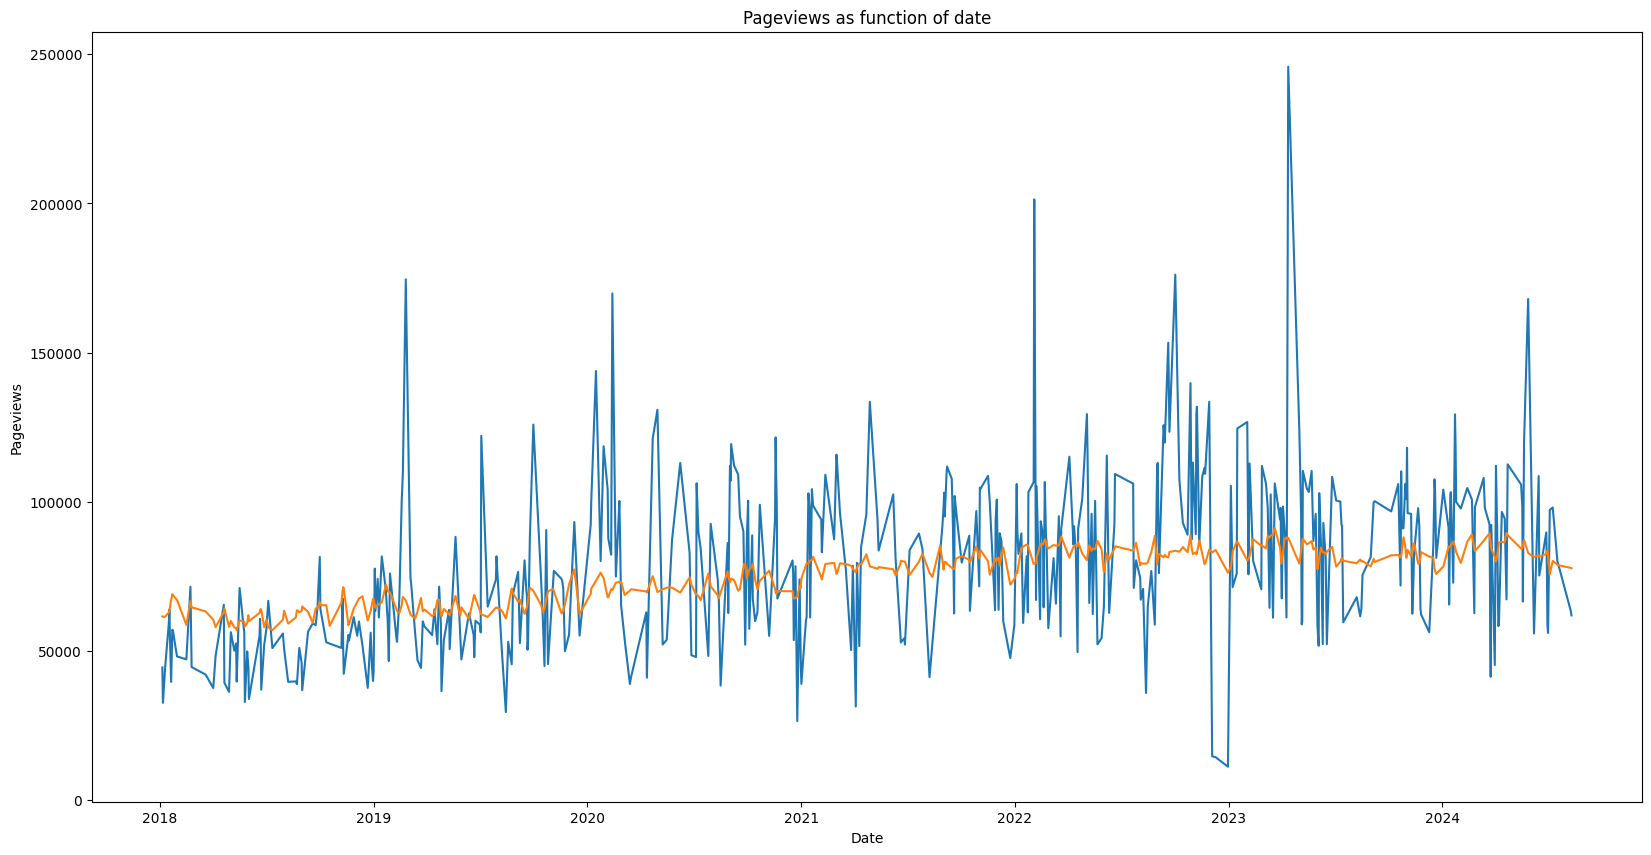

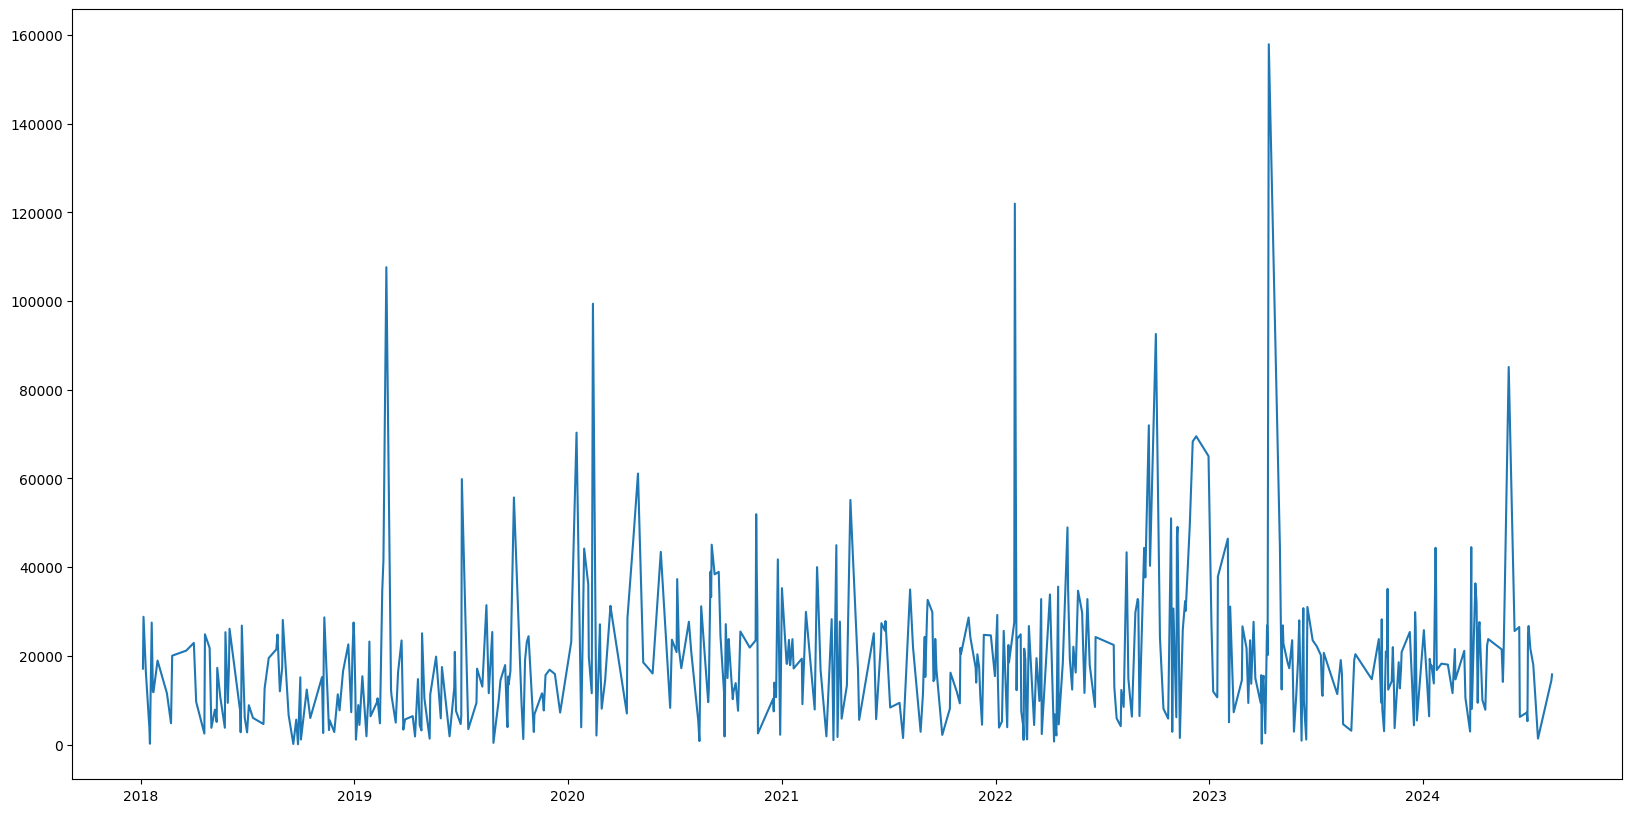

In [92]:
best_model = grid_search.best_estimator_

best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)

evaluate(y_test, y_pred)

# plot pageviews as function of date (combine year, month, day)

dates = x_test['anno'].astype(str) + '-' + x_test['mese_num'].astype(str) + '-' + x_test['giorno'].astype(str)
dates = pd.to_datetime(dates)

plt.figure(figsize=(20, 10))

new_df = pd.DataFrame({'date': dates, 'pageviews': y_test})

new_df = new_df.sort_values(by='date')

plt.plot(new_df['date'], new_df['pageviews'])

new_df = pd.DataFrame({'date': dates, 'pageviews': y_pred})
new_df = new_df.sort_values(by='date')
plt.plot(new_df['date'], new_df['pageviews'])

plt.xlabel('Date')
plt.ylabel('Pageviews')
plt.title('Pageviews as function of date')
plt.show()


# on a new plot plot the absolute error as function of date

plt.figure(figsize=(20, 10))

new_df = pd.DataFrame({'date': dates, 'error': np.abs(y_test - y_pred)})
new_df = new_df.sort_values(by='date')
plt.plot(new_df['date'], new_df['error'])



# Comparing Different Models Performance

## Model Building

In [90]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'SVM': SVR()
}

## Model Comparison

In [78]:
results = {}
for name, model in models.items():
  results[name] = -cross_val_score(model, x_train, y_train, cv=k_fold, scoring='neg_mean_absolute_error')
  
results = pd.DataFrame(results).transpose()

results['mean'] = results.mean(axis=1)
results['std'] = results.std(axis=1)
results['relative_error'] = results.mean(axis=1) / y_train.mean()

results = results.sort_values('mean', ascending=True)

results

,0,1,2,3,4,5,6,7,8,9,mean,std,relative_error
Random Forest,16224.424433,15386.809948,17668.907720,14942.020259,15489.135907,14555.840622,16381.015855,17381.633990,15937.736943,15880.063627,15984.758930,935.283112,0.191536
KNN,18698.915464,16808.972165,19858.261140,15523.482902,17924.278756,17210.894301,17377.697409,18728.070466,19494.967876,17270.425907,17889.596639,1252.373285,0.214584
Decision Tree,20417.561856,18189.969072,23285.160622,15592.823834,18534.844560,17611.108808,17933.766839,21458.844560,19464.492228,18490.461140,19097.903352,2057.784560,0.229858
Linear Regression,21250.647965,19214.451010,22480.223523,18450.023862,20495.143692,18777.747451,18332.274868,19917.398723,21530.555557,18430.141064,19887.860772,1412.219752,0.238575
SVM,24949.375466,23624.535102,26572.283976,21668.408625,23406.335696,22171.916349,21764.076475,23591.962876,24313.682578,21806.014850,23386.859199,1520.130833,0.280396
